In [1]:
import pandas as pd
import numpy as np
import tensorflow

from PIL import Image
from urllib.request import urlopen
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.layers import BatchNormalization, Dense, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV, train_test_split

### Load dataset

In [2]:
df = pd.read_csv("/kaggle/input/fashion-data/FASHION.csv").drop("Unnamed: 0", axis=1)

In [3]:
df.sample(10)

,asin,related,title,price,salesRank,imUrl,brand,categories,description,rating,timestamp,imUrl_local,user
1260,B00A2DRCG0,"{'also_viewed': ['B00JEOCUVU', 'B00CM5T30Y', '...",Mens Khussa Shoes Zari Embroidery Punjabi Jutt...,39.99,{'Shoes': 291044},http://ecx.images-amazon.com/images/I/41-ahF78...,NaN,Shoes,NaN,4.0,1.378858e+09,B00A2DRCG0_41-ahF78-1L._SX395_.jpg,USER760623463
91,B00BWYET1E,"{'also_viewed': ['B006TN6G6O', 'B00BWYETSM', '...","Necktie Set by Paul Malone 100% Silk Tie, Hand...",29.99,{'Clothing': 1056722},http://ecx.images-amazon.com/images/I/61wdMUwD...,NaN,Clothing Men,NaN,4.0,1.375142e+09,B00BWYET1E_61wdMUwD0sL._SX342_.jpg,USER651437252
1448,B00HG5HBW2,"{'also_bought': ['B00D86DFJG'], 'also_viewed':...",ASICS GEL-FOUNDATION 11 Women's Running Shoes,104.98,{'Shoes': 63719},http://ecx.images-amazon.com/images/I/51vXR3-6...,NaN,Shoes,NaN,5.0,1.401149e+09,B00HG5HBW2_51vXR3-6sVL._SX395_.jpg,USER462769646
175,B004AUN8VY,"{'also_viewed': ['B008HL9FXW', 'B00JJASISS', '...",Ford Mustang Car Logo Embroidered Panel Club S...,39.99,{'Clothing': 290037},http://ecx.images-amazon.com/images/I/41vqZ4pT...,NaN,Clothing Men,NaN,5.0,1.339978e+09,B004AUN8VY_41vqZ4pTG0L._SX342_.jpg,USER521508928
1115,B00IOT3UME,"{'also_bought': ['B00IOT4EL0'], 'also_viewed':...",Dr. Comfort Gary Flex-OA Men's Shoe for Knee P...,109.95,{'Shoes': 72965},http://ecx.images-amazon.com/images/I/41mb6yfq...,NaN,Shoes,NaN,4.0,1.403050e+09,B00IOT3UME_41mb6yfqiFL._SY395_.jpg,USER264503626
1352,B00EURFYZU,"{'also_viewed': ['B00ESZGX7C', 'B00G92YZ40', '...",SHOEZY Trend Womens Strap High Heels Platform ...,45.99,{'Shoes': 171400},http://ecx.images-amazon.com/images/I/51azwnfk...,NaN,Shoes,NaN,4.0,1.395619e+09,B00EURFYZU_51azwnfksYL._SY395_.jpg,USER263407153
1848,B004TBLB36,"{'also_viewed': ['B005WUF71U', 'B00BHNAS6A', '...",Android Men's AD508BS Ninja 50 Classic Automa...,128.24,{'Watches': 104072},http://ecx.images-amazon.com/images/I/41olcK90...,Android,Watches,NaN,4.0,1.335744e+09,B004TBLB36_41olcK90R2L._SY300_.jpg,USER994928536
794,B00E5LVVB2,"{'also_viewed': ['B00E5LUPGY', 'B00CLB0PBA', '...","NO H8, Equal Sign NO HATE Ladies Junior Fit V-...",18.95,{'Clothing': 364048},http://ecx.images-amazon.com/images/I/41N46x1l...,NaN,Clothing Women,NaN,5.0,1.401926e+09,B00E5LVVB2_41N46x1lFDL._SX342_.jpg,USER878671728
1788,B000BDIQPW,"{'also_viewed': ['B008X6JBG2', 'B000HKGT0I', '...",Seiko Women's SXD694 Coutura Diamond Watch,199.00,{'Watches': 30673},http://ecx.images-amazon.com/images/I/41JRKYKQ...,Seiko,Watches,NaN,4.0,1.209254e+09,B000BDIQPW_41JRKYKQLKL._SY300_.jpg,USER926740188
325,B008RJTJ4O,"{'also_viewed': ['B008RJSC7Y', 'B00HQBT5DY', '...",Buffalo David Bitton Men's Nikky T-Shirt,11.14,{'Clothing': 886238},http://ecx.images-amazon.com/images/I/41qvoKIR...,NaN,Clothing Men,NaN,5.0,1.354838e+09,B008RJTJ4O_41qvoKIR%2BTL._SX342_.jpg,USER578423608


### Data Preprocessing

In [4]:
def preprocess_data_for_vgg19(df):
    preprocessed_images = []
    preprocessed_labels = []
    for index, row in df.iterrows():
        try:
            response = urlopen(row['imUrl'])
            img = Image.open(response)
        except:
            continue
        img = img.resize((224, 224))
        img = img.convert('RGB')
        img_arr = np.array(img).astype(np.float32)
        if img_arr.shape != (224, 224, 3):
            continue
        img_arr = preprocess_input(img_arr)
        preprocessed_images.append(img_arr)
        preprocessed_labels.append(row['categories'])

    preprocessed_images = np.array(preprocessed_images)
    preprocessed_labels = np.array(preprocessed_labels)

    return preprocessed_images, preprocessed_labels

images, labels_ = preprocess_data_for_vgg19(df)
label_encoder = LabelEncoder()
labels_ = label_encoder.fit_transform(labels_)

labels = to_categorical(labels_, num_classes=4)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size = 0.3, random_state=42)

### Model Pretrained VGG19

In [6]:
def create_model(dropout=0.5, learning_rate=0.0001):
    base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout)(x)
    predictions = Dense(4, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=learning_rate), metrics=['accuracy'])
    return model

In [7]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)

estimator = KerasClassifier(build_fn=create_model, epochs=10, batch_size=32, verbose=0)

param_grid = {'dropout': [0.5, 0.7],
              'learning_rate': [0.001, 0.0001]}

grid_search = GridSearchCV(estimator=estimator, param_grid=param_grid, cv=3, verbose=1)

grid_search_result = grid_search.fit(X_train, y_train, validation_split=0.2, callbacks=[early_stopping, checkpoint])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  after removing the cwd from sys.path.


Fitting 3 folds for each of 4 candidates, totalling 12 fits
80134624/80134624 [==============================] - 0s 0us/step

Epoch 1: val_accuracy improved from -inf to 0.79570, saving model to best_model.h5

Epoch 2: val_accuracy improved from 0.79570 to 0.80108, saving model to best_model.h5

Epoch 3: val_accuracy improved from 0.80108 to 0.83333, saving model to best_model.h5

Epoch 4: val_accuracy improved from 0.83333 to 0.83871, saving model to best_model.h5

Epoch 5: val_accuracy improved from 0.83871 to 0.84409, saving model to best_model.h5

Epoch 6: val_accuracy improved from 0.84409 to 0.84946, saving model to best_model.h5

Epoch 7: val_accuracy improved from 0.84946 to 0.86022, saving model to best_model.h5

Epoch 8: val_accuracy did not improve from 0.86022

Epoch 9: val_accuracy did not improve from 0.86022

Epoch 10: val_accuracy did not improve from 0.86022

Epoch 1: val_accuracy did not improve from 0.86022

Epoch 2: val_accuracy did not improve from 0.86022

Epoch 3

In [8]:
print("Best: %f using %s" % (grid_search_result.best_score_*100, grid_search_result.best_params_))

Best: 85.394790 using {'dropout': 0.5, 'learning_rate': 0.001}


### Evaluate

In [9]:
# load best model
best_model = create_model(dropout=grid_search_result.best_params_['dropout'], 
                          learning_rate=grid_search_result.best_params_['learning_rate'])
best_model.load_weights('/kaggle/working/best_model.h5')

# evaluate on test set
test_loss, test_accuracy = best_model.evaluate(X_test, y_test, verbose=1)
print(f"Test loss: {test_loss:.4f}, Test accuracy: {test_accuracy:.4f}")

19/19 [==============================] - 4s 193ms/step - loss: 0.5678 - accuracy: 0.8308
Test loss: 0.5678, Test accuracy: 0.8308


### Predict

19/19 [==============================] - 2s 71ms/step


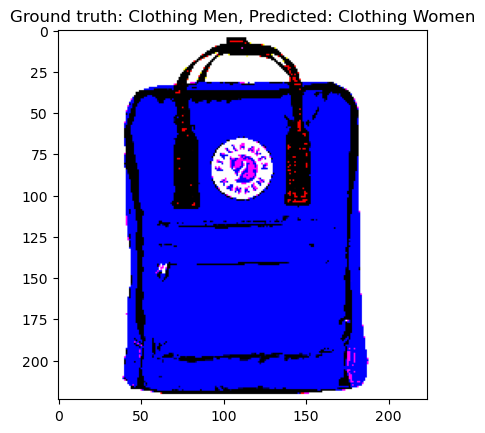

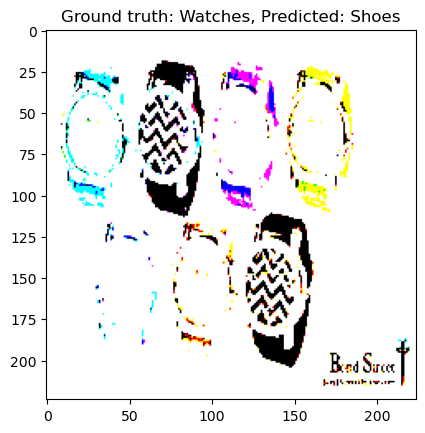

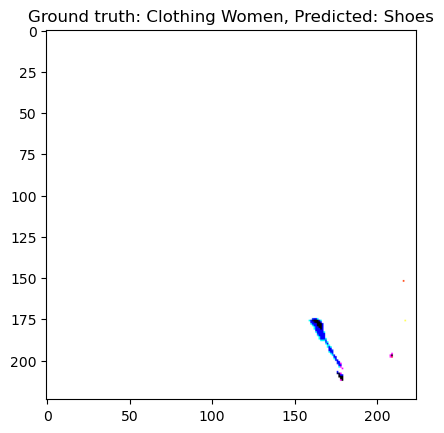

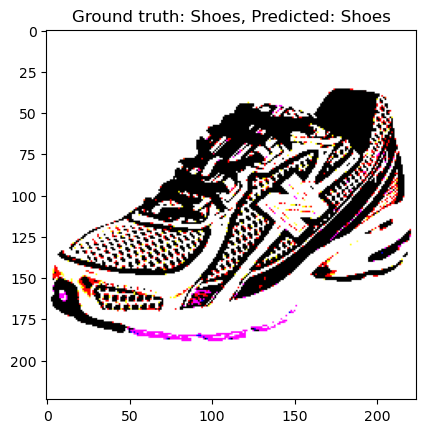

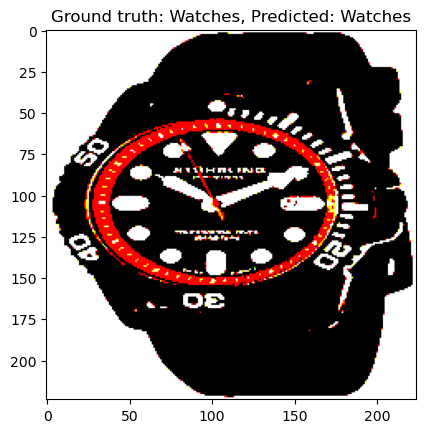

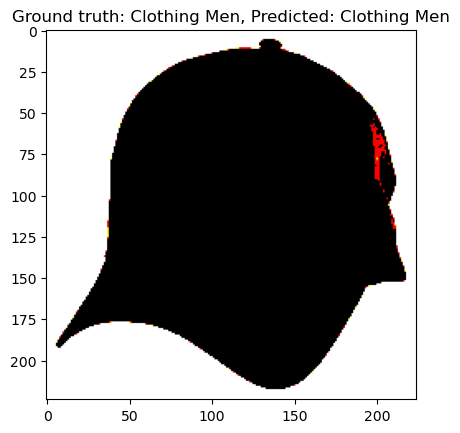

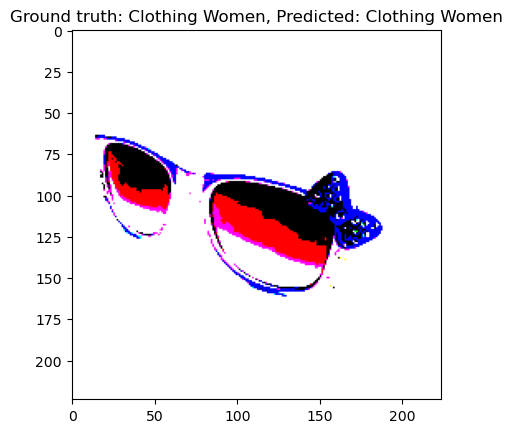

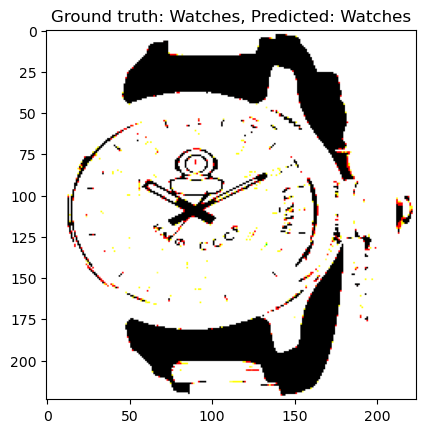

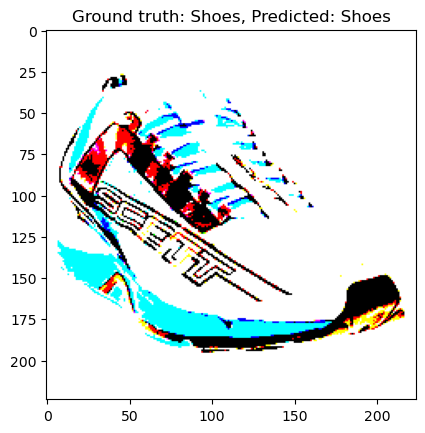

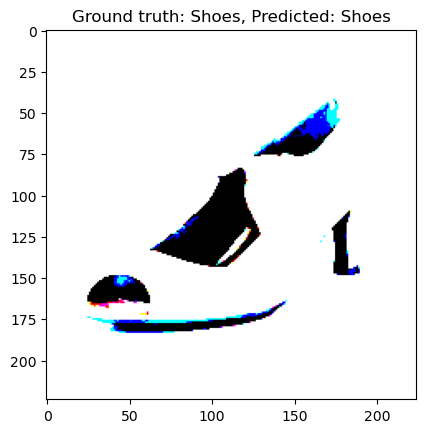

In [10]:
import matplotlib.pyplot as plt 
def plot_image_with_label(image, label):
    plt.imshow(image, cmap='viridis')
    plt.title(label)
    plt.show()

# make predictions on test set
test_predicted_labels_ = best_model.predict(X_test)
test_predicted_labels = np.argmax(test_predicted_labels_, axis=1)
test_predicted_labels = label_encoder.inverse_transform(test_predicted_labels)

# plot some test images with predicted labels
for i in range(10):
    image = X_test[i]
    ground_truth_label = label_encoder.inverse_transform([np.argmax(y_test[i])])[0]
    predicted_label = test_predicted_labels[i]
    plot_image_with_label(image, f"Ground truth: {ground_truth_label}, Predicted: {predicted_label}")